In [8]:
# %pip install numpy networkx matplotlib scikit-learn seaborn wordcloud textblob --quiet

In [1]:
%pip install gensim pyLDAvis


   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.0 MB ? eta -:--:--
    --------------------------------------- 0.5/24.0 MB 932.9 kB/s eta 0:00:26
   - -------------------------------------- 0.8/24.0 MB 1.1 MB/s eta 0:00:21
   - -------------------------------------- 1.0/24.0 MB 1.3 MB/s eta 0:00:18
   -- ------------------------------------- 1.3/24.0 MB 1.2 MB/s eta 0:00:19
   -- ------------------------------------- 1.6/24.0 MB 1.3 MB/s eta 0:00:18
   --- ------------------------------------ 1.8/24.0 MB 1.2 MB/s eta 0:00:18
   --- ------------------------------------ 2.1/24.0 MB 1.3 MB/s eta 0:00:18
   --- ------------------------------------ 2.1/24.0 MB 1.3 MB/s eta 0:00:18
   ---- ----------------------------------- 2.6/24.0 MB 1.1 MB/s eta 0:00:19
   ---- ----------------------------------- 2.6/24.0 MB 1.1 MB/s eta 0:00:19
   ----- ---------

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from utils.GraphConstructor import GraphConstructor
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import networkx as nx
from deep_translator import GoogleTranslator
import pickle

In [10]:
graph_builder = GraphConstructor()
graph_builder.build_graph()
graph = graph_builder.graph

In [11]:
class ContentPolarizationAnalyzer:
    def __init__(self, graph):
        """
        Analizzatore di polarizzazione dei contenuti.
        :param graph: Il grafo orientato (nx.DiGraph).
        """
        self.graph = graph

    def extract_user_opinions(self):
        """
        Estrae le opinioni (contenuto testuale) degli utenti dal grafo.
        :return: Dizionario {user_id: testo_completo}
        """
        user_opinions = {}
        for node, data in self.graph.nodes(data=True):
            threads = data.get("user_data", [])
            if threads is None:
                threads = []
            user_opinions[node] = " ".join(thread.get("Caption Text", "") for thread in threads)
        return user_opinions

    def perform_sentiment_analysis(self, user_opinions):
        """
        Analizza il sentiment dei testi degli utenti.
        :param user_opinions: Dizionario {user_id: testo_completo}.
        :return: Dizionario {user_id: sentiment_score}.
        """
        sentiment_scores = {}
        for user_id, text in user_opinions.items():
            sentiment_scores[user_id] = TextBlob(text).sentiment.polarity
        return sentiment_scores

    def cluster_users(self, user_opinions, method="kmeans", n_clusters=5):
        """
        Raggruppa gli utenti in base al contenuto pubblicato.
        :param user_opinions: Dizionario {user_id: testo_completo}.
        :param method: Metodo di clustering ("kmeans" o "dbscan").
        :param n_clusters: Numero di cluster (per K-means).
        :return: Dizionario {user_id: cluster_label}.
        """
        vectorizer = TfidfVectorizer(stop_words="english")
        tfidf_matrix = vectorizer.fit_transform(user_opinions.values())

        if method == "kmeans":
            clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
        elif method == "dbscan":
            clustering_model = DBSCAN(metric="cosine", eps=0.5, min_samples=5)
        else:
            raise ValueError("Metodo di clustering non supportato: usa 'kmeans' o 'dbscan'.")

        cluster_labels = clustering_model.fit_predict(tfidf_matrix)
        return dict(zip(user_opinions.keys(), cluster_labels))

    def visualize_clusters(self, user_opinions, cluster_labels):
        """
        Visualizza i cluster degli utenti su due dimensioni principali.
        :param user_opinions: Dizionario {user_id: testo_completo}.
        :param cluster_labels: Dizionario {user_id: cluster_label}.
        """
        vectorizer = TfidfVectorizer(stop_words="english")
        tfidf_matrix = vectorizer.fit_transform(user_opinions.values())

        svd = TruncatedSVD(n_components=2)
        reduced_data = svd.fit_transform(tfidf_matrix)

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x=reduced_data[:, 0], 
            y=reduced_data[:, 1], 
            hue=list(cluster_labels.values()), 
            palette="viridis"
        )
        plt.title("Cluster di utenti basati sul contenuto")
        plt.xlabel("Dimensione 1")
        plt.ylabel("Dimensione 2")
        plt.legend(title="Cluster")
        plt.show()

    def identify_polarizing_themes(self, user_opinions, cluster_labels):
        """
        Identifica i temi più polarizzanti in base ai cluster.
        :param user_opinions: Dizionario {user_id: testo_completo}.
        :param cluster_labels: Dizionario {user_id: cluster_label}.
        :return: Lista di parole chiave polarizzanti.
        """
        vectorizer = TfidfVectorizer(stop_words="english")
        tfidf_matrix = vectorizer.fit_transform(user_opinions.values())
        feature_names = vectorizer.get_feature_names_out()

        polarizing_words = []
        for cluster in set(cluster_labels.values()):
            cluster_indices = [i for i, label in enumerate(cluster_labels.values()) if label == cluster]
            cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
            top_words = [feature_names[i] for i in np.argsort(-cluster_tfidf.A[0])[:10]]
            polarizing_words.extend(top_words)

        return list(set(polarizing_words))

    def visualize_polarizing_themes(self, polarizing_words):
        """
        Crea una word cloud dei temi più polarizzanti.
        :param polarizing_words: Lista di parole polarizzanti.
        """
        word_cloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(polarizing_words))

        plt.figure(figsize=(10, 6))
        plt.imshow(word_cloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Temi più polarizzanti")
        plt.show()

In [12]:
analyzer = ContentPolarizationAnalyzer(graph)

In [13]:
user_opinions = analyzer.extract_user_opinions()

In [14]:
# Analisi del sentiment
sentiment_scores = analyzer.perform_sentiment_analysis(user_opinions)
print("Sentiment Scores:", sentiment_scores)

Sentiment Scores: {62926993725: 0.2886392839787682, 11781456417: 0.0, 37102490442: 0.0, 531758406: 0.364189708141321, 60850232106: 0.30737179487179483, 11194920225: 0.0, 55968501995: 0.0, 49013546684: 0.0, 60628346710: 0.0, 4153445941: 0.0, 3756730580: 0.0, 42554616: 0.0, 4536264575: 0.0, 65391034968: 0.0, 384363191: 0.0, 6253539944: 0.0, 38798206844: 0.0, 65070693281: 0.0, 60966856788: 0.0, 69566543810: 0.0, 5547173328: 0.0, 38077850387: 0.0, 5701199225: 0.0, 5676816145: 0.0, 51958843096: 0.0, 55178050501: 0.0, 64379260940: 0.0, 50139636118: 0.0, 262856836: 0.165137741046832, 3156028036: 0.0, 54579428206: 0.0, 9047692314: 0.0, 10027598301: 0.0, 7355542106: 0.0, 36095397789: 0.0, 5520169129: 0.0, 56714285656: 0.0, 34158564957: 0.0, 6649417310: 0.0, 50656527917: 0.0, 8362525031: 0.0, 62233317658: 0.26250000000000007, 1501070805: 0.0, 1816863531: 0.0, 1027867451: 0.0, 6150800787: 0.0, 3519965980: 0.0, 1795971330: 0.5, 563838818: 0.0, 1543214540: 0.0, 5672499286: 0.0, 3098195771: 0.201298

In [16]:
# Clustering degli utenti
cluster_labels = analyzer.cluster_users(user_opinions, method="dbscan")
print("Cluster Labels:", cluster_labels)

Cluster Labels: {62926993725: np.int64(-1), 11781456417: np.int64(-1), 37102490442: np.int64(-1), 531758406: np.int64(-1), 60850232106: np.int64(-1), 11194920225: np.int64(-1), 55968501995: np.int64(-1), 49013546684: np.int64(-1), 60628346710: np.int64(6), 4153445941: np.int64(-1), 3756730580: np.int64(-1), 42554616: np.int64(-1), 4536264575: np.int64(-1), 65391034968: np.int64(-1), 384363191: np.int64(-1), 6253539944: np.int64(-1), 38798206844: np.int64(-1), 65070693281: np.int64(-1), 60966856788: np.int64(-1), 69566543810: np.int64(-1), 5547173328: np.int64(-1), 38077850387: np.int64(-1), 5701199225: np.int64(-1), 5676816145: np.int64(-1), 51958843096: np.int64(-1), 55178050501: np.int64(-1), 64379260940: np.int64(-1), 50139636118: np.int64(-1), 262856836: np.int64(-1), 3156028036: np.int64(-1), 54579428206: np.int64(-1), 9047692314: np.int64(-1), 10027598301: np.int64(-1), 7355542106: np.int64(-1), 36095397789: np.int64(-1), 5520169129: np.int64(-1), 56714285656: np.int64(-1), 34158

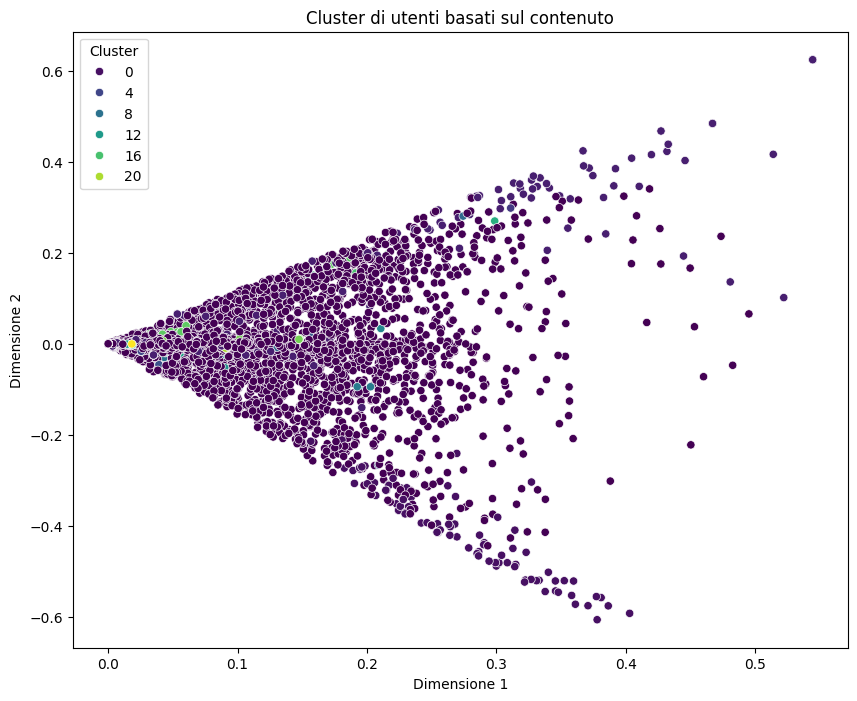

In [17]:
# Visualizza i cluster
analyzer.visualize_clusters(user_opinions, cluster_labels)

In [18]:
# Identifica e visualizza i temi polarizzanti
polarizing_themes = analyzer.identify_polarizing_themes(user_opinions, cluster_labels)
print("Polarizing Themes:", polarizing_themes)

Polarizing Themes: ['yeah', 'te', 'se', 'guys', 'proposals', 'thank', 'vé', 'work', 'connect', 'wow', 'chatgptprompts', 'million', 'ig', 'web', 'term', 'careers', 'le', 'got', 'let', 'pm', 'ji', 'right', '00', 'por', 'world', 'hey', 'field', 'journey', 'sexy', 'invest_with_middle_class_guy', 'nhận', 'que', 'ayomideameh', 'day', 'share', 'thông', '𝑚𝑒', 'programming', 'appleintelligence', 'course', 'cloud', 'com', 'happened', 'business', 'org', 'yes', 'talking', 'tiktok', 'cake', 'più', 'tiếp', 'abandoned', 'matrix', '𝑦𝑜𝑢', 'las', 'll', 'aws', 'igsh', 'data', 'datavisualization', 'add', 'comment', 'xin', 'rozay', 'sei', 'điệp', 'mathematics', 'online', 'neural', 'datascientist', 'write', '𝟭𝟵', 'riya_hirani_0909', 'notifications', 'time', 'il', 'machine', 'chatgpt', 'help', 'bang', 'simplicity', 'computing', 'service', 'visualization', 'datacarpentry', 'birthday', 'modules', 'www', 'lo', 'est', 'une', 'times', 'collaborate', 'like', 'deeplearning', 'utm_source', '𝟭𝟲', 'luck', 'aiart', 'ne

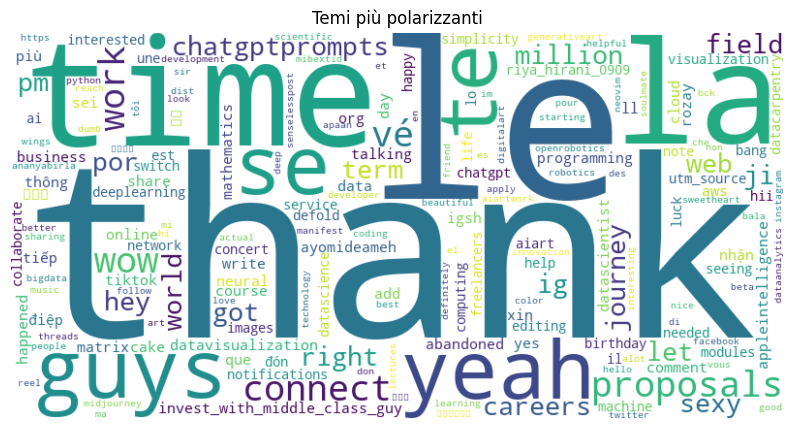

In [19]:
analyzer.visualize_polarizing_themes(polarizing_themes)